In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from crystalvision.data import dataset
from crystalvision.data.dataset import paths_and_labels_to_dataset


df = dataset.imagine_database()

# Ignore by language
# df = df.query(f"~filename.str.contains('_eg')")  # English
df = df.query(f"~filename.str.contains('_fr')")  # French
df = df.query(f"~filename.str.contains('_es')")  # Spanish
df = df.query(f"~filename.str.contains('_it')")  # Italian
df = df.query(f"~filename.str.contains('_de')")  # German
df = df.query(f"~filename.str.contains('_jp')")  # Japanese

df.drop(["images"], axis=1, inplace=True)
for lang in ("_es", "_de", "_fr", "_it"):
    df = df.loc[:,~df.columns.str.endswith(lang)]
# df.sort_values('code', ascending=False, inplace=True)

codes, uniques = df["mono"].factorize()
X_train, X_test, y_train, y_test = train_test_split(df['filename'],
                                                    codes,
                                                    test_size=0.33,
                                                    random_state=23,
                                                    shuffle=True,
                                                    stratify=df[["mono", "type_en"]])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# df

In [3]:
from crystalvision.data.dataset import extend_dataset

orig_ds = paths_and_labels_to_dataset(
    image_paths=X_train.tolist(),
    image_size=(250, 179),
    num_channels=3,
    labels=y_train.tolist(),
    label_mode="binary",
    num_classes=len(uniques),
    interpolation="bilinear",
    # crop_to_aspect_ratio=crop_to_aspect_ratio,
)

In [4]:
def adjust_brightness(img, val):
    if os.environ["KERAS_BACKEND"] == "torch":
        from torchvision import transforms
        img = transforms.ColorJitter(brightness=(1 + val, 1 + val)).forward(img.permute(2, 0, 1))
        img = img.permute(1, 2, 0)
    else:
        import tensorflow as tf
        img = tf.image.adjust_brightness(img, val)
    return img

In [5]:
def adjust_contrast(img, val):
    if os.environ["KERAS_BACKEND"] == "torch":
        from torchvision import transforms
        img = transforms.ColorJitter(contrast=(val, val)).forward(img.permute(2, 0, 1))
        img = img.permute(1, 2, 0)
    else:
        import tensorflow as tf
        img = tf.image.adjust_contrast(img, val)
    return img

In [6]:
def adjust_saturation(img, val):
    if os.environ["KERAS_BACKEND"] == "torch":
        from torchvision import transforms
        img = transforms.ColorJitter(saturation=(val, val)).forward(img.permute(2, 0, 1))
        img = img.permute(1, 2, 0)
    else:
        import tensorflow as tf
        img = tf.image.adjust_contrast(img, val)
    return img

In [7]:
def random_hue(img, val):
    if os.environ["KERAS_BACKEND"] == "torch":
        from torchvision import transforms
        img = transforms.ColorJitter(hue=val).forward(img.permute(2, 0, 1))
        img = img.permute(1, 2, 0)
    else:
        import tensorflow as tf
        img = tf.image.adjust_contrast(img, val)
    return img

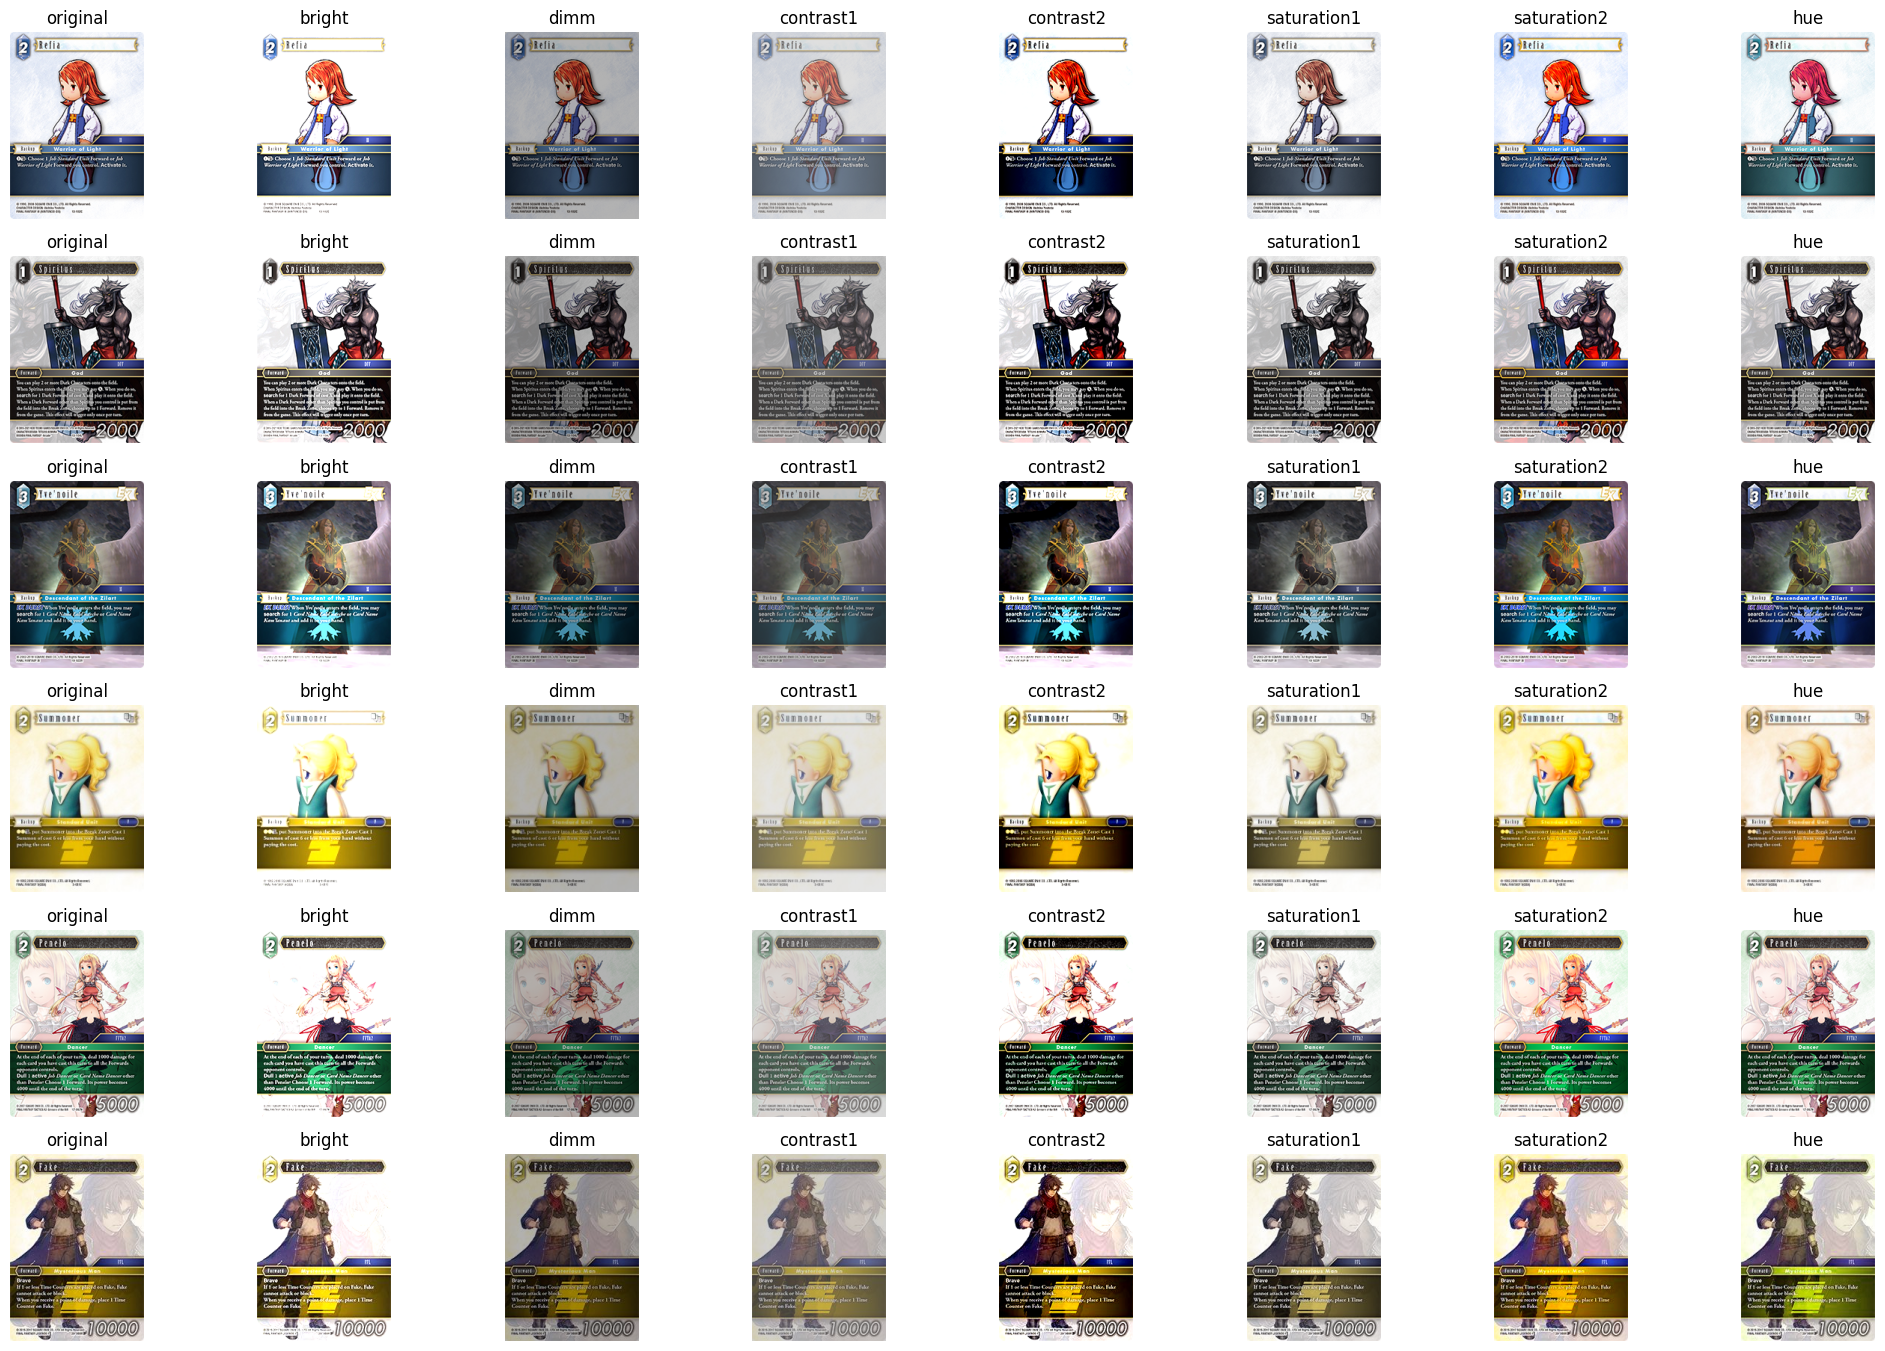

In [8]:
%matplotlib inline

import keras.ops as ops
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25, 17))

# orig_ds.skip(128).take(4)

for j, (img, _) in enumerate(orig_ds.batch(1)):
    if j >= 6: break
    img = img[0]

    imgs = {
        "original": img,
        "bright": ops.clip(adjust_brightness(img, 0.3), 0, 1.0).cpu(),
        "dimm": ops.clip(adjust_brightness(img, -0.3), 0, 1.0).cpu(),
        "contrast1": ops.clip(adjust_contrast(img, 0.60), 0, 1.0).cpu(),
        "contrast2": ops.clip(adjust_contrast(img, 1.5), 0, 1.0).cpu(),
        "saturation1": ops.clip(adjust_saturation(img, 0.5), 0, 1.0).cpu(),
        "saturation2": ops.clip(adjust_saturation(img, 1.85), 0, 1.0).cpu(),
        "hue": ops.clip(random_hue(img, 0.075), 0, 1.0).cpu(),
    }

    for i, (title, img) in enumerate(imgs.items()):
        fig.add_subplot(6, len(imgs), 1 + i + (j * len(imgs)))
        plt.axis('off')
        plt.imshow(img)
        plt.title(title)

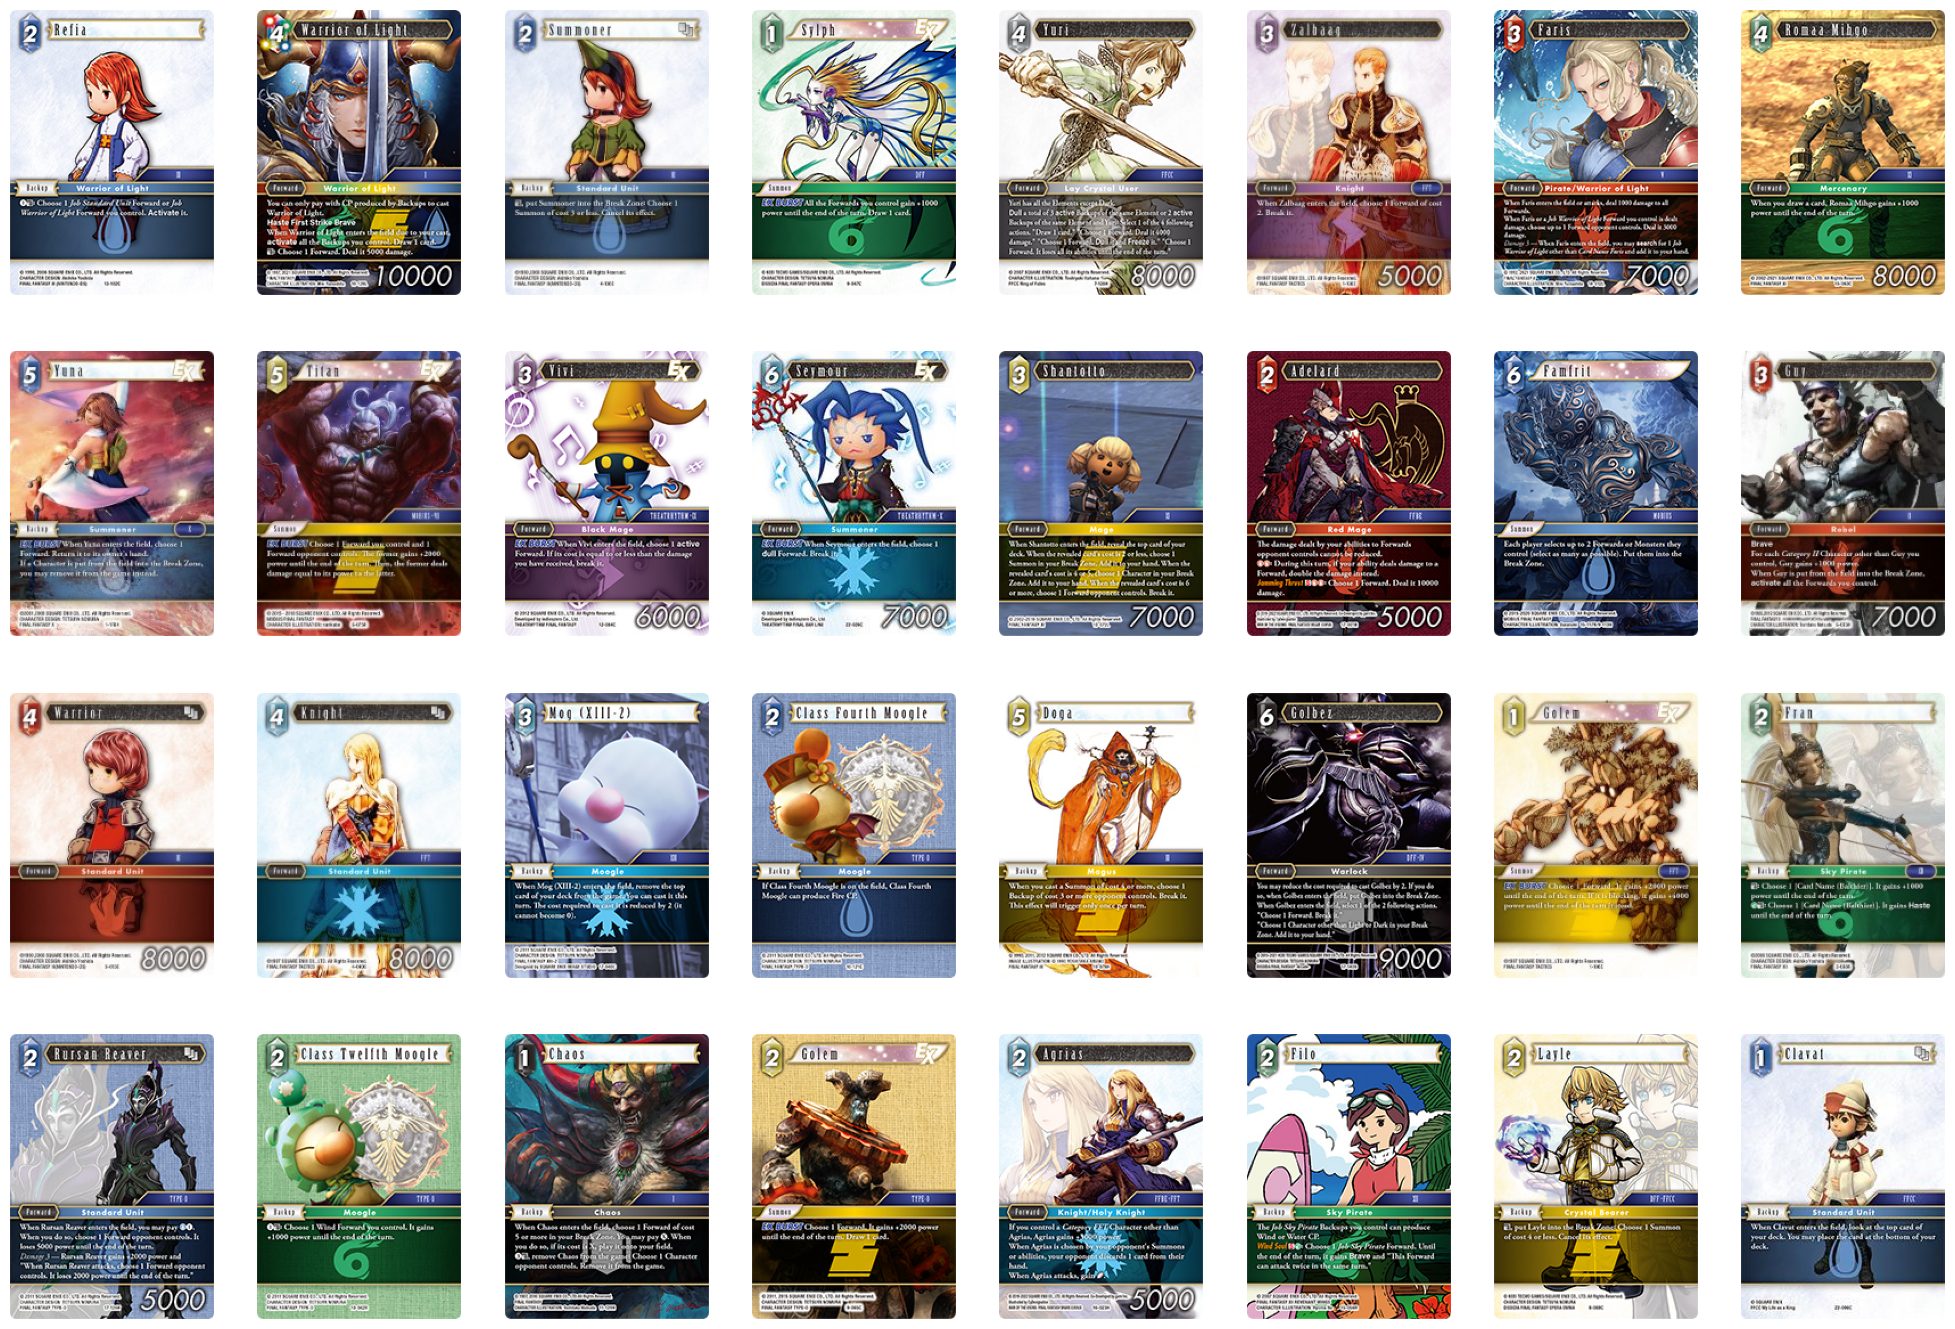

In [9]:
fig = plt.figure(figsize=(25, 17))

ds = extend_dataset(orig_ds, seed=23, shuffle=False)

for images, labels in ds:
    for i, img in enumerate(images):
        fig.add_subplot(4, 8, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title("Second")
    break